In [1]:
import wandb
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from dataset_class import CustomImageDataset
from model_class import ConvNet, ResNet18
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
config = dict(
    epochs=10,
    batch_size=32,
    learning_rate=0.001,
    dataset="russian-wildlife-dataset",
    architecture="CNN",
    seed=2022028)

In [3]:
class_names = ['amur_leopard', 'amur_tiger', 'birds', 'black_bear', 'brown_bear', 'dog', 'roe_deer', 'sika_deer', 'wild_boar', 'people' ]
img_dir = 'russian-wildlife-dataset/Cropped_final'  
images = []
labels = []
for i in range(len(class_names)):
    class_dir = os.path.join(img_dir, class_names[i])
    class_size = 0
    try:
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_names[i], img_name)
            images.append(img_path)
            labels.append(i)

    except FileNotFoundError:
        print(f"Directory for label '{class_names[i]}' not found")

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state = config['seed'])

In [4]:
def visualize(class_names, labels, title, color= 'skyblue'):
    distribution = [0] * len(class_names)
    for i in labels:
        distribution[i] += 1
    print(f"{title}:")
    for name, count in zip(class_names, distribution):
        print(f"  {name}: {count}")

    keys = class_names
    values = distribution
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color=color, edgecolor='black')
    plt.xlabel("Class Names")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  
    plt.show()

Training Data Distribution:
  amur_leopard: 783
  amur_tiger: 839
  birds: 1157
  black_bear: 780
  brown_bear: 967
  dog: 970
  roe_deer: 899
  sika_deer: 1231
  wild_boar: 1148
  people: 560


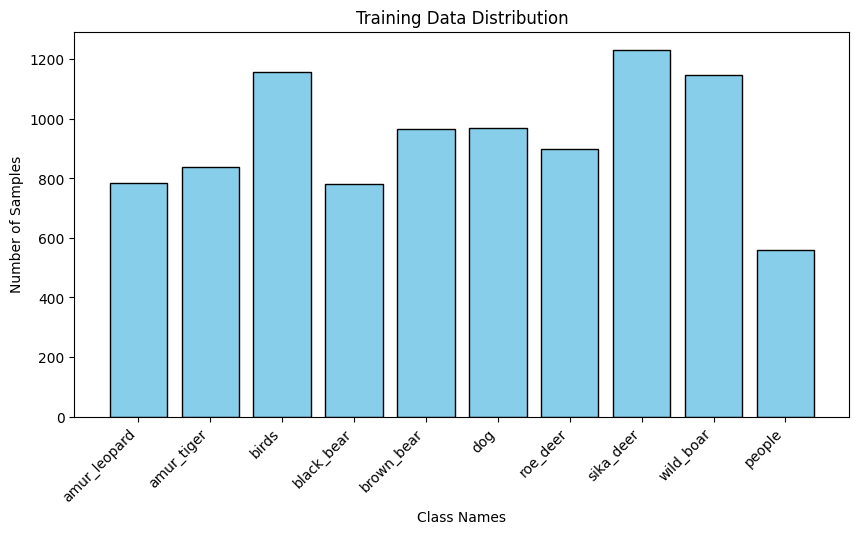

Validation Data Distribution:
  amur_leopard: 195
  amur_tiger: 210
  birds: 289
  black_bear: 195
  brown_bear: 242
  dog: 243
  roe_deer: 225
  sika_deer: 308
  wild_boar: 287
  people: 140


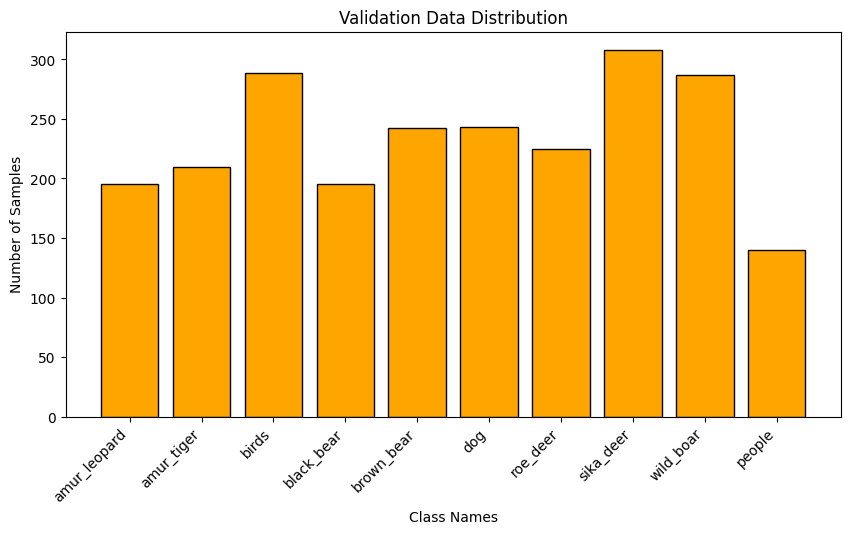

In [33]:
visualize(class_names, train_labels, "Training Data Distribution", color='skyblue')
visualize(class_names, val_labels, "Validation Data Distribution", color='orange')

In [5]:
def train(train_dataloader, val_dataloader, device, model, criterion, optimizer, config, model_name):
    best_val_loss = float("inf")
    for epoch in range(config.epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0
        num_train_samples = 0
        num_val_samples = 0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_batch_size = images.size(0)
            train_loss += loss.item() * curr_batch_size
            num_train_samples += curr_batch_size

        average_train_loss = train_loss/num_train_samples

        model.eval()
        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                curr_batch_size = images.size(0)
                val_loss += loss.item() * curr_batch_size
                num_val_samples += curr_batch_size

        average_val_loss = val_loss/num_val_samples

        wandb.log({"epoch": epoch + 1, "train_loss": average_train_loss, "val_loss": average_val_loss})
        print(f"EPOCH: {epoch+1} | TRAIN LOSS: {average_train_loss} | VAL LOSS: {average_val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"weights/{model_name}.pth")
    print(f"weights saved at weights/{model_name}.pth")


In [6]:
def test(val_dataloader, device, weight_dir, model_class, class_names):
    model = model_class().to(device)
    model.load_state_dict(torch.load(weight_dir))
    model.eval()
    
    preds = []
    y_true = []
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred_batch = torch.max(outputs.data, 1)
            preds.extend(pred_batch.tolist())
            y_true.extend(labels.tolist())
        wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None, preds=preds, y_true=y_true, class_names=class_names)})
        print("confusion matrix saved to wandb")
        accuracy = sum(np.array(preds) == np.array(y_true)) / len(y_true)
        f1 = f1_score(y_true, preds, average="weighted")
        print(f"ACCURACY: {accuracy:.4f}")
        print(f"F1 SCORE: {f1:.4f}")

In [7]:
def model_pipeline(model_name, config, is_train=True, is_test=True):
    wandb.login()
    with wandb.init(project=model_name, config=config):
        config = wandb.config

        random.seed(config.seed)
        np.random.seed(config.seed)
        torch.manual_seed(config.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(config.seed)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        transform = v2.Compose([
            v2.ConvertImageDtype(torch.float32),
            v2.Resize((224, 224)), 
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        transform_aug = v2.Compose([
            v2.ConvertImageDtype(torch.float32),
            v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), antialias=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        if model_name == "convnet":
            train_dataset = CustomImageDataset(img_dir, train_images, train_labels, transform=transform)
            model_class = ConvNet
            weight_dir = "weights/convnet.pth"
        elif model_name == "resnet":
            train_dataset = CustomImageDataset(img_dir, train_images, train_labels, transform=transform)
            model_class = ResNet18
            weight_dir = "weights/resnet.pth"

        elif model_name == "resnet_aug":
            train_dataset = CustomImageDataset(img_dir, train_images, train_labels, transform=transform_aug)
            model_class = ResNet18
            weight_dir = "weights/resnet_aug.pth"
        else:
            raise ValueError(f"Unknown model name: {model_name}")
        train_dataloader = DataLoader(train_dataset, config.batch_size, shuffle=True)

        val_dataset = CustomImageDataset(img_dir, val_images, val_labels, transform=transform)
        val_dataloader = DataLoader(val_dataset, config.batch_size, shuffle=False)
        
        if is_train:
            model = model_class().to(device)        
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
            print(f"Training {model_name}:")
            train(train_dataloader, val_dataloader, device, model, criterion, optimizer, config, model_name)

        if is_test:
            print(f"Evaluation of {model_name} on VAL SET:")
            test(val_dataloader, device, weight_dir, model_class, class_names)

In [8]:
model_pipeline(model_name="convnet", config=config, is_train=False)

wandb: Currently logged in as: aditya22028 (aditya22028-indraprastha-institute-of-information-techno) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Evaluation of convnet on VAL SET:
confusion matrix saved to wandb
ACCURACY: 0.6384
F1 SCORE: 0.6332


In [9]:
model_pipeline(model_name="resnet", config=config, is_train=False)

Evaluation of resnet on VAL SET:
confusion matrix saved to wandb
ACCURACY: 0.8355
F1 SCORE: 0.8355


In [10]:
model_pipeline(model_name="resnet_aug", config=config, is_train=False)

Evaluation of resnet_aug on VAL SET:
confusion matrix saved to wandb
ACCURACY: 0.8132
F1 SCORE: 0.8134
